# Imports

In [60]:
# imports
import numpy as np
from tueplots import bundles, figsizes
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from analysis import sweep2df, plot_typography


In [62]:
USETEX = True

In [63]:
plt.rcParams.update(bundles.neurips2022(usetex=USETEX))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

In [64]:
plot_typography(usetex=USETEX, small=12, medium=16, big=20)

In [128]:
# Constants
ENTITY = "causal-representation-learning"
PROJECT = "sam_test"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

## SAM and VAE sanity check

In [160]:
SWEEP_ID = "e0geelo2"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sam_vae_{SWEEP_ID}"
df_sam_vae, sam_val_loss, sam_val_scale_inv, _, sam_recon_loss_no_sam = sweep2df(sweep.runs, filename, save=True, load=False)

## Fix encoder variance

In [142]:
SWEEP_ID = "4aggfh82"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"fix_enc_var_sweep_{SWEEP_ID}"
df_fix_enc_var, fix_enc_val_loss, fix_enc_val_scale_inv, _, fix_enc_val_recon_loss_no_sam = sweep2df(sweep.runs, filename, save=True, load=False)

## RAE

In [147]:
SWEEP_ID = "dzf5aufj" #"kmnl40of"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"rae_sweep_{SWEEP_ID}"
df_rae, rae_val_loss, rae_val_scale_inv, rae_val_grad_loss, rae_val_recon_loss_no_sam = sweep2df(sweep.runs, filename, save=True, load=False)

# Pre-processing


In [68]:
enc_vars = df_fix_enc_var.enc_var.unique()
latent_dim = df_fix_enc_var.latent_dim.unique()
sqrt_dim = np.sqrt(latent_dim)

## SAM and VAE sanity check

In [161]:
scale_no_sam = sam_val_scale_inv[ df_sam_vae.sam_update ==False]
scale_sam = sam_val_scale_inv[df_sam_vae.sam_update ==True]

loss_no_sam = sam_val_loss[ df_sam_vae.sam_update ==False]
loss_sam = sam_val_loss[df_sam_vae.sam_update ==True]


val_rec_no_sam_no_sam = sam_recon_loss_no_sam[df_sam_vae.sam_update ==False]
val_rec_no_sam_sam = sam_recon_loss_no_sam[df_sam_vae.sam_update ==True]

## Fix encoder variance

In [145]:
scale_enc_var_no_sam = {var: fix_enc_val_scale_inv[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
scale_enc_var_sam = {var: fix_enc_val_scale_inv[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

loss_enc_var_no_sam = {var: fix_enc_val_loss[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
loss_enc_var_sam = {var: fix_enc_val_loss[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

val_rec_no_sam_enc_var_no_sam = {var: fix_enc_val_recon_loss_no_sam[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
val_rec_no_sam_enc_var_sam = {var: fix_enc_val_recon_loss_no_sam[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

## RAE

In [144]:
scale_rae = {var: rae_val_scale_inv[df_rae.enc_var == var] for var in enc_vars}
grad_rae = {var: rae_val_grad_loss[df_rae.enc_var == var] for var in enc_vars}
loss_rae = {var: rae_val_loss[df_rae.enc_var == var] for var in enc_vars}
recon_loss_no_sam_rae = {var: rae_val_recon_loss_no_sam[df_rae.enc_var == var] for var in enc_vars}

# Plots

## SAM and VAE sanity check

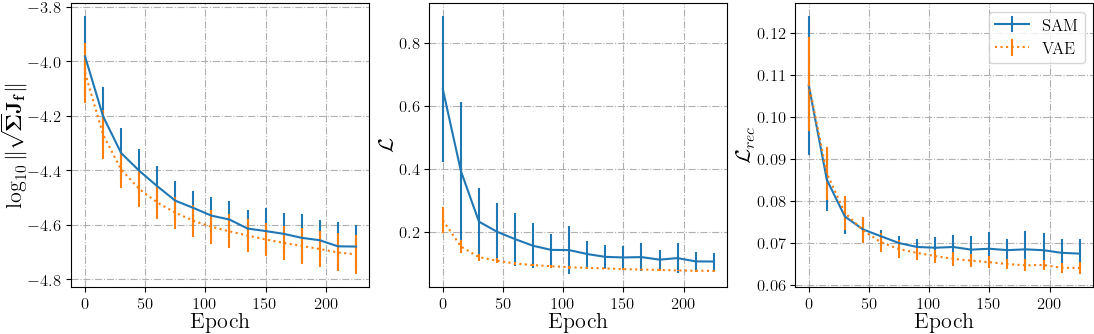

In [166]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(131)
ax.grid(True, which="both", ls="-.")


if len(scale_sam) > 0:
    val_epoch_ticks = range(0, scale_sam.shape[1] * val_epoch_factor, val_epoch_factor)
    ax.errorbar(val_epoch_ticks, np.log10(scale_sam*sqrt_dim).mean(0), np.log10(scale_sam*sqrt_dim).std(0), c=COLORS[0], label=f"SAM", ls="solid")
    ax.errorbar(val_epoch_ticks, np.log10(scale_no_sam*sqrt_dim).mean(0), np.log10(scale_no_sam*sqrt_dim).std(0), c=COLORS[1], label="VAE", ls="dotted")


ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\sqrt{\mathbf{\Sigma}}\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)


ax = fig.add_subplot(132)
ax.grid(True, which="both", ls="-.")


if len(loss_sam) > 0:
    val_epoch_ticks = range(0, loss_sam.shape[1] * val_epoch_factor, val_epoch_factor)
    ax.errorbar(val_epoch_ticks, loss_sam.mean(0), loss_sam.std(0), c=COLORS[0], label=f"SAM", ls="solid")
    ax.errorbar(val_epoch_ticks, loss_no_sam.mean(0), loss_no_sam.std(0), c=COLORS[1], label="VAE", ls="dotted")



ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)

ax = fig.add_subplot(133)
ax.grid(True, which="both", ls="-.")


if len(val_rec_no_sam_sam) > 0:
    val_epoch_ticks = range(0, val_rec_no_sam_sam.shape[1] * val_epoch_factor, val_epoch_factor)
    ax.errorbar(val_epoch_ticks, val_rec_no_sam_sam.mean(0), val_rec_no_sam_sam.std(0), c=COLORS[0], label=f"SAM", ls="solid")
    ax.errorbar(val_epoch_ticks, val_rec_no_sam_no_sam.mean(0), val_rec_no_sam_no_sam.std(0), c=COLORS[1], label="VAE", ls="dotted")



ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}_{rec}$", labelpad=LABELPAD)


plt.legend(loc="upper right")
plt.savefig("loss_grad_sam_no_sam.svg")

## Fix encoder variance

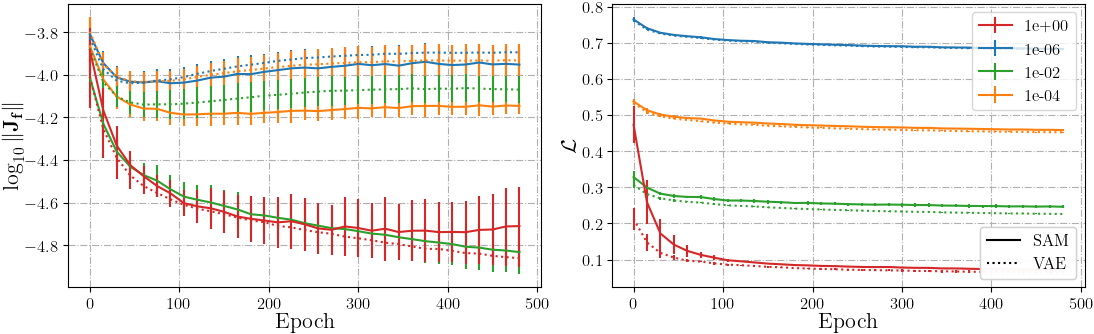

In [136]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15


fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(121)
ax.grid(True, which="both", ls="-.")



for (var, inv_scale_sam), inv_scale_no_sam, inv_scale_rae, color in zip(scale_enc_var_sam.items(),scale_enc_var_no_sam.values(), scale_rae.values(), COLORS):
    if len(inv_scale_sam) > 0:
        std = np.sqrt(var)
        val_epoch_ticks = range(0, len(inv_scale_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_sam/std*sqrt_dim).mean(0), np.log10(inv_scale_sam/std*sqrt_dim).std(0), c=color, label=f"{var:.0e}", ls="solid")
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_no_sam/std*sqrt_dim).mean(0), np.log10(inv_scale_no_sam/std*sqrt_dim).std(0), c=color, label=f"{var:.0e}", ls="dotted")



ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)



ax = fig.add_subplot(122)
ax.grid(True, which="both", ls="-.")

for (var, l_sam), l_no_sam, l_rae, color in zip(loss_enc_var_sam.items(), loss_enc_var_no_sam.values(), loss_rae.values(), COLORS):
    if len(l_sam) > 0:
        val_epoch_ticks = range(0, len(l_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, l_sam.mean(0), l_sam.std(0), c=color, label=f"{var:.0e}", ls="solid")
        ax.errorbar(val_epoch_ticks, l_no_sam.mean(0), l_no_sam.std(0), c=color, label=f"{var:.0e}", ls="dotted")


# Create the color-based legend and set its location
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles = [handles[labels.index(label)] for label in unique_labels]
labels = unique_labels
legend1 = ax.legend(handles, labels, loc='upper right')

# Create the linestyle-based legend and set its location
line_sam = mlines.Line2D([], [], color='black', linestyle='solid', label='solid')
line_no_sam = mlines.Line2D([], [], color='black', linestyle='dotted', label='dotted')
handles2 = [line_sam, line_no_sam]
labels2 = ['SAM', 'VAE']
legend2 = ax.legend(handles2, labels2, loc='lower right')

ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)

# Add the linestyle-based legend to the color-based legend
ax.add_artist(legend1)
ax.add_artist(legend2)


# plt.legend(loc="upper right")
plt.savefig("loss_grad_fix_enc_var.svg")

# SAM ksiebb rhoval is simabba teszi a gradienseket (TBC)

## RAE

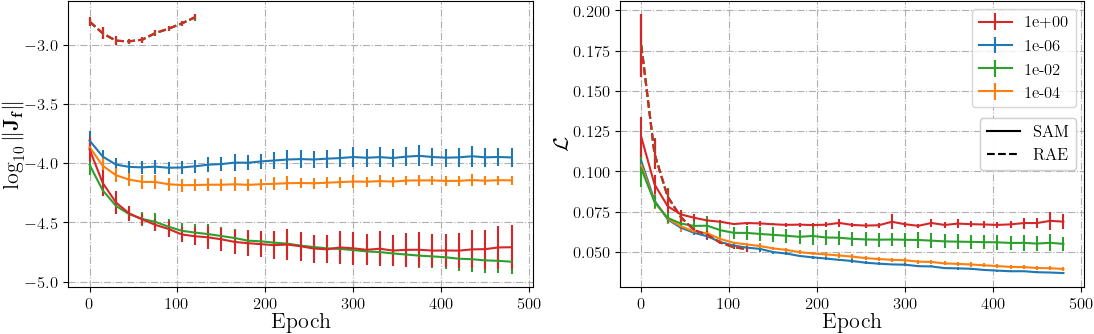

In [159]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(121)
ax.grid(True, which="both", ls="-.")


for (var, inv_scale_sam), inv_scale_rae, color in zip(scale_enc_var_sam.items(), scale_rae.values(), COLORS):
    if len(inv_scale_sam) > 0:
        std = np.sqrt(var)
        val_epoch_ticks = range(0, len(inv_scale_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_sam/std*sqrt_dim).mean(0), np.log10(inv_scale_sam/std*sqrt_dim).std(0), c=color, label=f"{var:.0e}", ls="solid")


        val_epoch_ticks = range(0, len(inv_scale_rae[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_rae/std*sqrt_dim).mean(0), np.log10(inv_scale_rae/std*sqrt_dim).std(0), c=color, label=f"{var:.0e}", ls="dashed")





ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)


ax = fig.add_subplot(122)
ax.grid(True, which="both", ls="-.")



for (var, l_sam), l_rae, color in zip(val_rec_no_sam_enc_var_sam.items(),  recon_loss_no_sam_rae.values(), COLORS):
    if len(l_sam) > 0:
        val_epoch_ticks = range(0, len(l_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, l_sam.mean(0), l_sam.std(0), c=color, label=f"{var:.0e}", ls="solid")

        val_epoch_ticks = range(0, len(l_rae[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, l_rae.mean(0), l_rae.std(0), c=color, label=f"{var:.0e}", ls="dashed")


ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)






# Create the color-based legend and set its location
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles = [handles[labels.index(label)] for label in unique_labels]
labels = unique_labels
legend1 = ax.legend(handles, labels, loc='upper right')

# Create the linestyle-based legend and set its location
line_sam = mlines.Line2D([], [], color='black', linestyle='solid', label='solid')
line_no_sam = mlines.Line2D([], [], color='black', linestyle='dashed', label='dashed')
handles2 = [line_sam, line_no_sam]
labels2 = ['SAM', 'RAE']
legend2 = ax.legend(handles2, labels2, loc='right')

ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)

# Add the linestyle-based legend to the color-based legend
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.savefig("loss_grad_rae.svg")